## Multi-label prediction with Planet Amazon dataset

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

## Getting the data

In [0]:
! pip install -q kaggle

In [0]:
! {sys.executable} -m pip install kaggle --upgrade

In [0]:
! mkdir -p ~/.kaggle/
! cp kaggle.json ~/.kaggle/

In [7]:
!kaggle datasets download -d nikitarom/planets-dataset

 99% 1.48G/1.50G [00:14<00:00, 100MB/s]
100% 1.50G/1.50G [00:14<00:00, 107MB/s]


In [0]:
!unzip \planets-dataset.zip

## Multiclassification

In [9]:
df = pd.read_csv('/content/planet/planet/train_classes.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [0]:
path = '/content/planet/planet'

In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [0]:
np.random.seed(42)
src = (ImageList.from_csv( path, 'train_classes.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [0]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

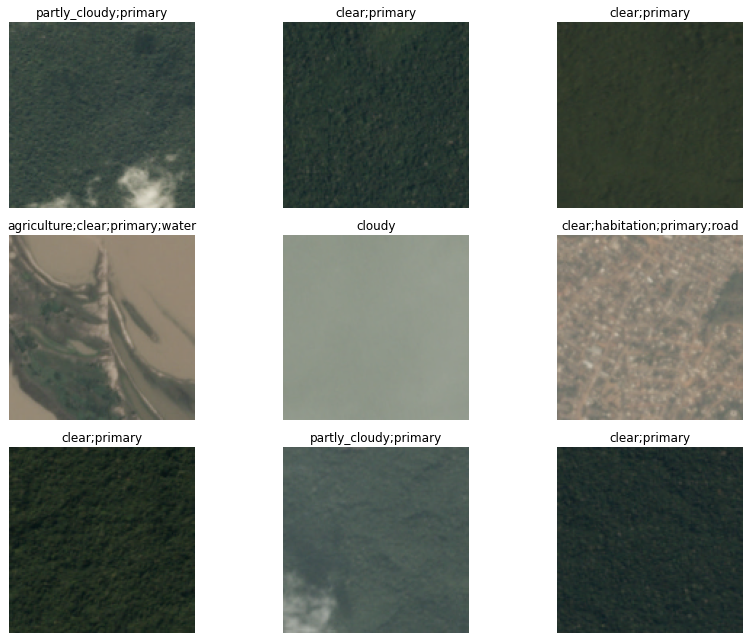

In [13]:
data.show_batch(rows=3, figsize=(12,9))

In [0]:
arch = models.resnet152

In [15]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score], wd=1e-1)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


We use the LR Finder to pick a good learning rate.

In [16]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


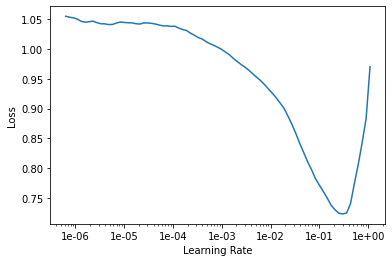

In [17]:
learn.recorder.plot()

Then we can fit the head of our network.

In [0]:
lr = 1e-1/3*2

In [19]:
learn.fit_one_cycle(4, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.142964,0.150001,0.951589,0.879954,02:18
1,0.143041,0.128342,0.946714,0.874457,02:18
2,0.115022,0.116365,0.950768,0.909715,02:18
3,0.097398,0.091339,0.958486,0.924524,02:19


In [20]:
learn.fit_one_cycle(1, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.103265,0.101094,0.956676,0.920488,02:18


In [0]:
learn.save('stage-1-rn154')

...And fine-tune the whole model:

In [0]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


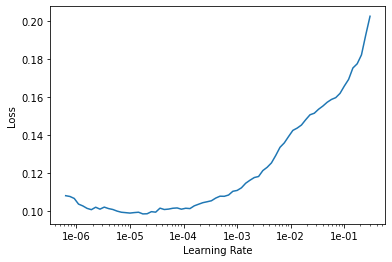

In [23]:
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(5, slice(1e-5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.102064,0.113156,0.955782,0.920720,03:04
1,0.100696,0.098357,0.956262,0.922730,03:05
2,0.098583,0.104819,0.956814,0.923417,03:05
3,0.096791,0.091365,0.958042,0.924393,03:05
4,0.098676,0.105819,0.956262,0.923222,03:04


In [37]:
learn.fit_one_cycle(1, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.093510,0.120188,0.955877,0.924367,03:04


In [0]:
learn.save('stage-2-rn154')

In [37]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [0]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


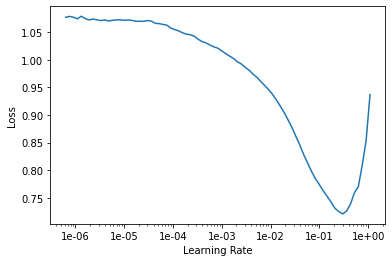

In [18]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr=1e-2/2

In [20]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.132137,0.108143,0.947121,0.904240,06:18
1,0.106704,0.096149,0.955252,0.917658,06:18
2,0.095546,0.087940,0.956313,0.923121,06:17
3,0.089400,0.085946,0.959808,0.926997,06:17
4,0.086455,0.084104,0.957868,0.928417,06:17


In [0]:
learn.save('stage-1-256-rn154')

In [0]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


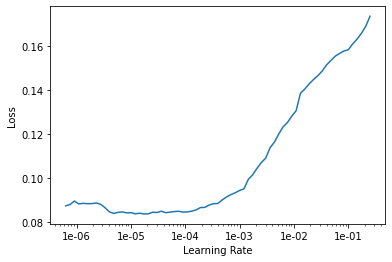

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(5, slice(1e-5, lr/10))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.093514,0.089277,0.956088,0.923630,08:19
1,0.090690,0.085023,0.957258,0.926787,08:20
2,0.084626,0.083389,0.957548,0.926424,08:20
3,0.082016,0.081554,0.958522,0.928721,08:20
4,0.076800,0.080705,0.959205,0.930405,08:20


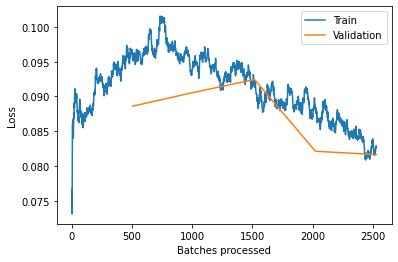

In [35]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-2-256-rn154')

In [0]:
learn.load('stage-2-256-rn154');

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

In [0]:
learn.export()

## fin

In [24]:
test = ImageList.from_folder('/content/planet/planet/test-jpg').add(ImageList.from_folder('/content/test-jpg-additional'))
len(test)

61191

In [0]:
learn = load_learner('/content/planet/planet', test=test)


In [29]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [31]:
labelled_preds[:5]

['agriculture clear habitation primary road',
 'agriculture clear haze primary road',
 'clear primary',
 'clear partly_cloudy primary',
 'agriculture cultivation partly_cloudy primary water']

In [0]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [0]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [0]:
df.to_csv('/content/planet/planet/submission.csv', index=False)

In [35]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {'/content/planet/planet/submission.csv'} -m "My submission"

100% 2.20M/2.20M [00:00<00:00, 3.46MB/s]
Successfully submitted to Planet: Understanding the Amazon from Space

Private Leaderboard score: 0.9301 (50th)